In [2]:

import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

In [100]:
def coregister_Seg_Dao_Pts(eclipse, band):
    
    segment_map, seg_sources = run_image_segmentation(eclipse, band)
        
    dao_pts, dao_extended, dao_crossreg, dao_summary = find_sources(eclipse, band)
    
    summary = {}
    
    sources_1 = seg_sources
    sources_2 = dao_crossreg
    
    # below and fun references are mostly michael's code from killscreen 
    mis_1, mis_2 = check_coregistration(sources_1, sources_2)
    sources = sources_1.loc[~mis_1].copy()
    summary["n_1"] = len(sources_1)
    summary["n_2"] = len(sources_2)
    summary["n_mismatch_1"] = len(np.nonzero(mis_1)[0])
    summary["n_mismatch_2"] = len(np.nonzero(mis_2)[0])
    summary["n_match"] = len(sources)
    sources["match"] = "both"
    mis_1_sources = sources_1.loc[mis_1].copy()
    mis_1_sources["match"] = "seg"
    mis_2_sources = sources_2.loc[mis_2].copy()
    mis_2_sources["match"] = "dao"
    all_sources = pd.concat((sources, mis_1_sources, mis_2_sources))
    
    return all_sources, summary, segment_map 

def run_image_segmentation(eclipse, band): 
    
    from photutils.segmentation import detect_sources
    from photutils.background import Background2D, MedianBackground
    from astropy.convolution import convolve
    from photutils.segmentation import make_2dgaussian_kernel
    from photutils.segmentation import SourceCatalog

    cnt_image = get_image_file(eclipse, band) # premasked

    bkg_estimator = MedianBackground()
    bkg = Background2D(cnt_image, (50, 50), filter_size=(3, 3),
                       bkg_estimator=bkg_estimator)
    cnt_image -= bkg.background  # subtract the background
    
    # define detection threshold (this is a 2D detection threshold
    # image made w/ background RMS image, 1.5 sigma per pixel 
    # noise level)

    threshold = 1.5 * bkg.background_rms

    kernel = make_2dgaussian_kernel(3, size=(7,7))# FWHM = 3.
    convolved_data = convolve(cnt_image, kernel)
    
    segment_map = detect_sources(convolved_data, threshold, npixels=3)

    # use segmentation map to make catalog w morpholgoy info 
    cat = SourceCatalog(cnt_image, segment_map, convolved_data=convolved_data)
    columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux', 'elongation', 
               'eccentricity', 'equivalent_radius', 'orientation']
    seg_sources = cat.to_table(columns=columns).to_pandas()
    #seg_sources.rename(columns={"xcentroid": "a", "ycentroid": "c"}) # jk I think it's supposed to be xcentroid 
    
    return segment_map, seg_sources

def display_ptandextended_sources(eclipse, band):
    # really only meant to be used for visualizing while avoiding a whole pipeline run 
    grouped_point_sources, extended_sources, all_sources, summary  = find_sources(eclipse, band)
    
    plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),interpolation='none')
    #plt.imshow(centile_clip(filtered))
    cmap = make_random_cmap(ncolors=5000,seed=23)

    for i, group in enumerate(grouped_point_sources.group_by('group_id').groups):
        for i2, point in enumerate(group):
            xypos = np.transpose([point['x_0'], point['y_0']])
            print(xypos)
            ap = CircularAperture(xypos, r= (point['npix']/3.14)**.5) # using area of kernel to get radius, not same as fwhm
            #ap.plot(color=cmap.colors[point['npix']], lw=(point['sharpness']*2))
            ap.plot(color=cmap.colors[point['npix']], lw=.75)
            #ap.plot(color="red", lw=abs(point['sharpness']*2)+.25)

        
    # convex hull around extended sources
    #for hull in enumerate(extended_sources): 
    #    plt.plot(list(zip(*hull[1]))[0],list(zip(*hull[1]))[1],'w-',lw=1.2)
    
    plt.show()

def find_sources(eclipse, band):

    # temporary work arounds until part of real pipeline:
    # calculating exp time from exp time csv
    exptime = calc_exp_time(eclipse, band)

    print(f"The exposure time is: {exptime}")

    cnt_image = get_image_file(eclipse, band)

    # TODO: don't hardcode this, do we need this?
    #  _ exptime < 300:
    #     print("Skipping low exposure time visit.")
    #     Path(datapath, "LowExpt").touch()
    #     return "Skipping low exposure time visit."

    # 3 point source runs of DAOStarFinder
    small_point_sources = smallStarFinder(cnt_image, exptime)
    med_point_sources = mediumStarFinder(cnt_image, exptime)
    big_point_sources = bigStarFinder(cnt_image, exptime)
    bigger_point_sources = evenBiggerStarFinder(cnt_image, exptime)

    summary = {}
    
    sources_1 = small_point_sources
    sources_2 = med_point_sources
    
    # below and fun references are mostly michael's code from killscreen 
    mis_1, mis_2 = check_coregistration(sources_1, sources_2)
    sources = sources_1.loc[~mis_1].copy()
    summary["n_1"] = len(sources_1)
    summary["n_2"] = len(sources_2)
    summary["n_mismatch_1"] = len(np.nonzero(mis_1)[0])
    summary["n_mismatch_2"] = len(np.nonzero(mis_2)[0])
    summary["n_match"] = len(sources)
    sources["match"] = "both"
    mis_1_sources = sources_1.loc[mis_1].copy()
    mis_1_sources["match"] = "1"
    mis_2_sources = sources_2.loc[mis_2].copy()
    mis_2_sources["match"] = "2"
    all_sources = pd.concat((sources, mis_1_sources, mis_2_sources))
    # add FWHM kernel size info to each row of sources table so that we know which star finder 
    # run found which source / to plot them accurately 

    # combine small and big point sources
    combined_point_sources = pd.concat([small_point_sources, med_point_sources, big_point_sources,bigger_point_sources])

    # DBSCANGroup for collecting point sources into groups
    grouped_point_sources, extended_sources = extendedSourceFinder(combined_point_sources)

    try:
        print(f"Located {len(grouped_point_sources)} point sources and {len(extended_sources)} extended sources.")
    except TypeError:
        print(f"{eclipse} {band} contains no sources.")
        return None, None

    return grouped_point_sources, extended_sources, all_sources, summary 

def check_coregistration(ref, comp, threshold=2):
    c_cols = ['xcentroid', 'ycentroid']
    ref_xy = ref[c_cols].to_numpy()
    comp_xy = comp[c_cols].to_numpy()
    ref_offsets = coregister_sources(ref_xy, comp_xy)
    comp_offsets = coregister_sources(comp_xy, ref_xy)
    return (
        ref_offsets > threshold, comp_offsets > threshold
    )

def coregister_sources(xy0, xy1):
    matches = []
    for source_ix in range(xy0.shape[0]):
        vec = xy0[source_ix]
        vec = np.expand_dims(vec, 1).T
        offsets = np.linalg.norm(xy1 - vec, axis=1)
        matches.append(offsets.argmin())
    sort_xy1 = xy1[matches]
    return np.linalg.norm(sort_xy1 - xy0, axis=1)

def smallStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=6, sigma_radius=1.5, threshold=0.004, ratio=1, theta=0, sharplo=0.05)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def mediumStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=6, sigma_radius=1.5, threshold=0.004, ratio=1, theta=0, sharplo=0.05)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def bigStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=5, sigma_radius=1.5, threshold=0.01, ratio=1, theta=0)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def evenBiggerStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=5, sigma_radius=2, threshold=0.01, ratio=1, theta=0)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def extendedSourceFinder(positions):
    """uses combined pt source list to identify clumped groups
    of stars as extended sources"""
    from astropy.table import QTable, Table, Column
    from photutils.psf.groupstars import DBSCANGroup

    eps = 40 # dist value for grouping, very important

    starlist = Table()
    starlist['x_0'] = positions["xcentroid"]
    starlist['y_0'] = positions["ycentroid"]
    starlist['sharpness'] = positions["sharpness"]    
    starlist['roundness1'] = positions["roundness1"]
    starlist['roundness2'] = positions["roundness2"]
    starlist['npix'] = positions["npix"]
    starlist['peak'] = positions["peak"]
    starlist['flux'] = positions["flux"]
    
    dbscan_group = DBSCANGroup(crit_separation=eps)
    source_table_grouped = dbscan_group(starlist)
    
    dbsc_groups = source_table_grouped.group_by('group_id')
    # characterize morphology (fit ellipse, convex hull) of each group above a
    # certain cutoff in size
    extended_source_table = extendedSourceMorphology(dbsc_groups)

    return source_table_grouped, extended_source_table

def extendedSourceMorphology(dbsc_groups):
    """uses convex hull on collection of pts id'd as in the same group to show shape of extended source"""
    from scipy.spatial import ConvexHull, convex_hull_plot_2d
    extended_source_table = []
    for i, group in enumerate(dbsc_groups.groups):
        if len(group) > 10:
            xypos = np.transpose([group['x_0'], group['y_0']])
            hull = ConvexHull(xypos)
            # might not be the best way to do this, but want # of points in the complex hull
            # so making a list with tuples of the (# of points, [the hull simplices pairs])
            #extended_source_table.append(hull.simplices)
            extended_source_table.append(list(zip(xypos[hull.vertices,0], xypos[hull.vertices,1])))
    return extended_source_table

def calc_exp_time(eclipse, band):
    """sums frame exposure times in exp time csv output by pipeline """
    from os.path import exists
    if band == "FUV":
        b = "fd"
    else:
        b = "nd"
    if exists(f"/home/bekah/glcat/exploration_notebooks/test_data/miniCat/e{eclipse}/e{eclipse}-{b}-30s-exptime.csv"):
        exp_time = pd.read_csv(f"/home/bekah/glcat/exploration_notebooks/test_data/miniCat/e{eclipse}/e{eclipse}-{b}-30s-exptime.csv")
        tot_exp_time = sum(exp_time["expt"])
    return tot_exp_time

def get_image_file(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/glcat/exploration_notebooks/test_data/miniCat', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]
    # masking cnt image
    masked_cnt_image = zero_flag_and_edge(cnt, flag, edge)
    return masked_cnt_image

# clipping 
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

def see_convolved(pic,k_size): 
    from astropy.convolution import convolve
    from photutils.segmentation import (detect_sources,
                                    make_2dgaussian_kernel)
    
    kernel = make_2dgaussian_kernel(3.0, size=3)  # FWHM = 3.
    convolved_data = convolve(pic, kernel)
    return convolved_data

The exposure time is: 1500.2286825052086
Located 34711 point sources and 1 extended sources.
{'n_1': 3799, 'n_2': 15246, 'n_mismatch_1': 684, 'n_mismatch_2': 12127, 'n_match': 3115}


<IPython.core.display.Javascript object>


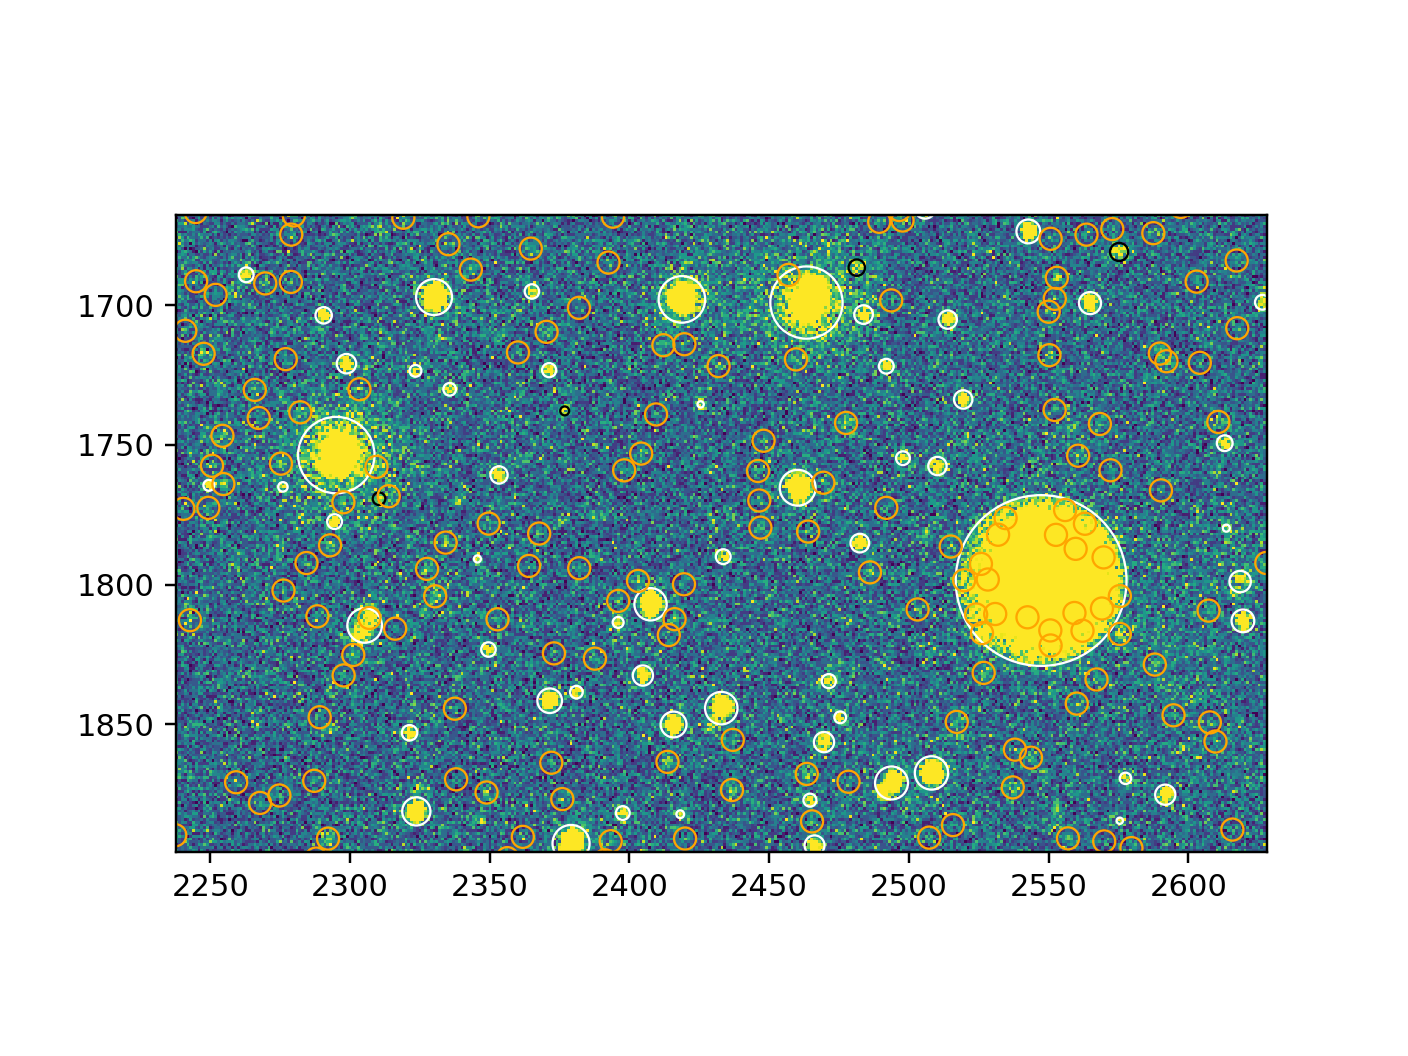

In [101]:
%matplotlib notebook


eclipse = "23456"
band = "NUV"

all_sources, summary, segment_map = coregister_Seg_Dao_Pts(eclipse, band)
   
print(summary)
    
#plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),cmap='Greys_r',interpolation='none')
plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),interpolation='none')

for index, point in all_sources.iterrows():
    
    if point['match']=="both":
        method = "white"
        method_r = point['equivalent_radius']
    if point['match']=="dao":
        method = "orange"
        method_r = (point['npix']/3.14)**.5
    elif point['match']=="seg":
        method = "black"
        method_r = point['equivalent_radius']
    
    xypos = np.transpose([point['xcentroid'], point['ycentroid']])
    
    ap = CircularAperture(xypos, r=method_r)
    ap.plot(color=method, lw=.75)
plt.show()



grouped_point_sources

In [84]:
both_ided = all_sources[all_sources["match"] == 'both']

In [85]:
both_ided

,label,xcentroid,ycentroid,area,segment_flux,elongation,eccentricity,equivalent_radius,orientation,match,id,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
19,20.0,1638.810685,177.045558,100.0,923.123912,2.070739,0.875665,5.641896,83.685566,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,26.0,1352.405403,182.795346,5.0,31.203377,1.689735,0.806078,1.261566,-71.164689,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,27.0,1493.196992,185.076362,39.0,316.209067,1.234395,0.586273,3.523363,-57.521675,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,28.0,1612.627037,184.183009,19.0,123.496801,1.298099,0.637613,2.459245,-78.394676,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,32.0,1727.737283,191.537155,33.0,214.646769,1.102094,0.420347,3.241022,-14.098894,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,3771.0,1597.394671,2899.058167,53.0,325.762240,1.795958,0.830643,4.107362,-83.114569,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3771,3772.0,1663.725343,2895.761247,8.0,72.846446,1.484037,0.738880,1.595769,-83.777649,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3772,3773.0,1669.519823,2894.514784,4.0,49.464512,1.001813,0.060129,1.128379,50.558915,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3774,3775.0,1713.554844,2902.475100,54.0,317.035245,1.493196,0.742628,4.145930,-50.353716,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
